In [38]:
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor 

ETL preeliminar

In [39]:
df_cat = pd.read_csv('bq-results-20230615-004316-1686789911775.csv')

In [40]:
business=pd.read_csv('Business.csv')

In [41]:
df_cat['Descripcion']=df_cat['Descripcion'].fillna('nodata')

In [42]:
df_cat['Descripcion']=df_cat['Descripcion'].apply(lambda x:x.strip())

In [43]:
df_cat=df_cat[~df_cat['id_business'].isin(df_cat[df_cat['Descripcion']=='nodata']['id_business'].to_list())]

In [44]:
df_ml=df_cat[df_cat['review_count']>15]

EDA

Categorias mas usadas por los negocios

In [45]:
df_ml.Descripcion.value_counts().head(20)

Restaurants                  14928
Food                          6895
Nightlife                     3639
Bars                          3395
Shopping                      3127
Beauty & Spas                 2550
American (Traditional)        2450
Sandwiches                    2323
Event Planning & Services     2187
American (New)                2068
Breakfast & Brunch            2002
Pizza                         2001
Coffee & Tea                  1834
Italian                       1535
Home Services                 1457
Health & Medical              1400
Burgers                       1398
Automotive                    1346
Local Services                1282
Fast Food                     1282
Name: Descripcion, dtype: int64

In [46]:
Ciudadestop=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Restaurants']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').head(10).index.to_list()
Estrellastop=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Restaurants']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').head(10)['stars'].to_list()
Ciudadestail=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Restaurants']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').tail(10).index.to_list()
Estrellastail=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Restaurants']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').tail(10)['stars'].to_list()

In [47]:
business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Restaurants']['id_business'].to_list())][['city','stars']].groupby('city').mean().head(5).tail(5).index.to_list()

['Albany', 'Allen', 'Allentown', 'Antioch', 'Arlington']

Como podemos observar en el siguiente grafico la misma categoria 'Restaurants' tiene diferente comportamiento en cuanto a las estrellas promedio en las distintas ciudades.

Text(0.5, 1.0, 'Restaurants')

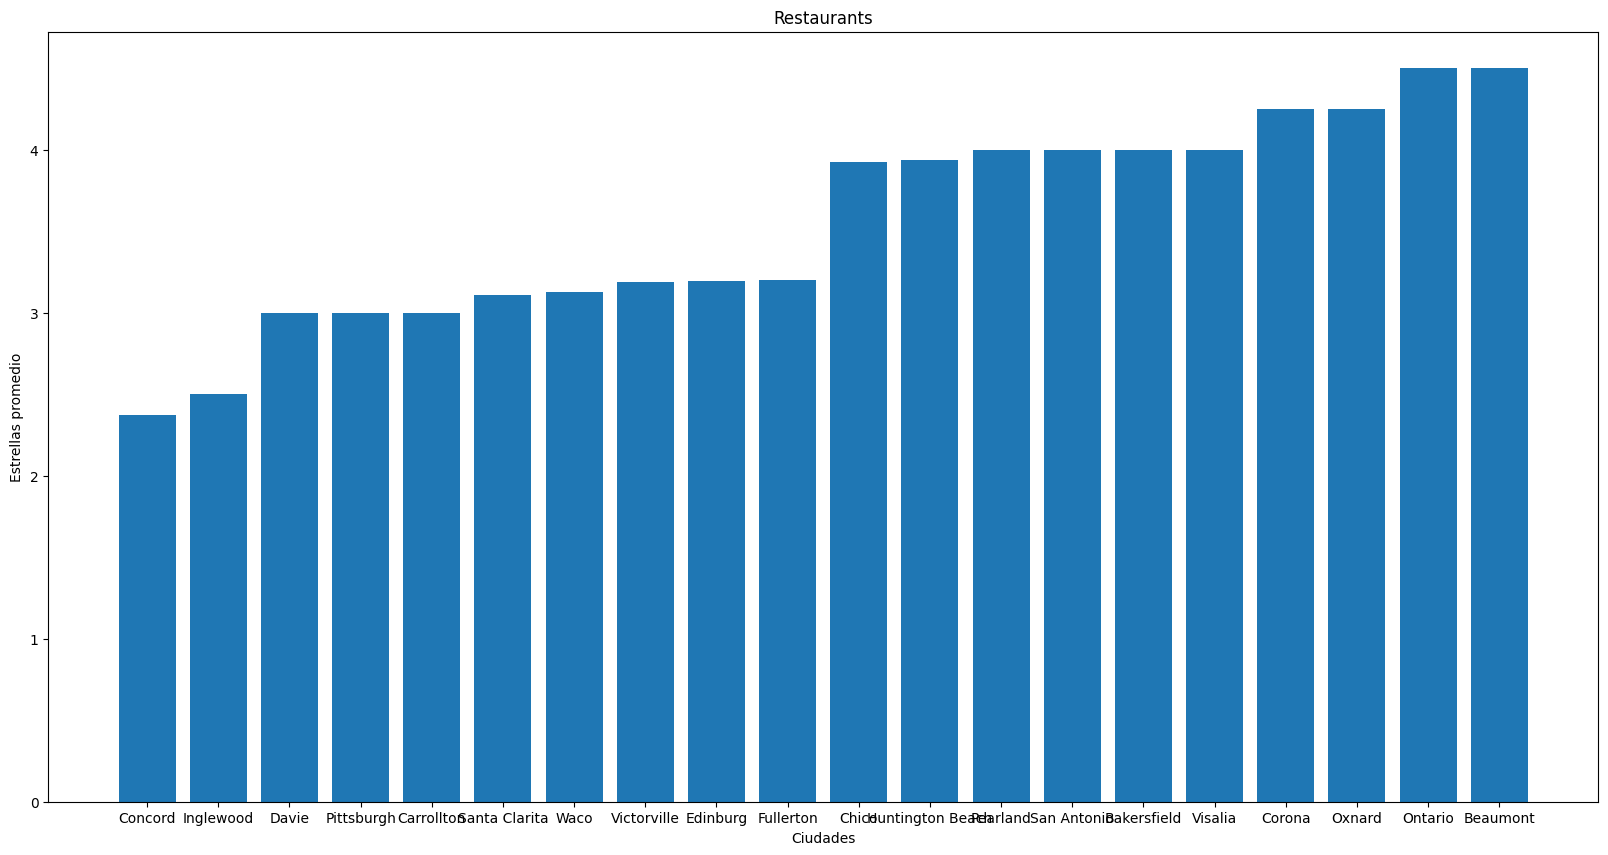

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
Ciudades=Ciudadestop+Ciudadestail
Estrellas=Estrellastop+Estrellastail
# Crear las barras
ax.bar(Ciudades, Estrellas)

# Etiquetas y título
ax.set_xlabel('Ciudades')
ax.set_ylabel('Estrellas promedio')
ax.set_title('Restaurants')

In [49]:
Ciudadestop=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Food']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').head(10).index.to_list()
Estrellastop=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Food']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').head(10)['stars'].to_list()
Ciudadestail=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Food']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').tail(10).index.to_list()
Estrellastail=business[business['id_business'].isin(df_ml[df_ml['Descripcion']=='Food']['id_business'].to_list())][['city','stars']].groupby('city').mean().sort_values('stars').tail(10)['stars'].to_list()

Esto demuestra una relacion entre la categoria y la ciudad con el promedio de estrellas.

Text(0.5, 1.0, 'Food')

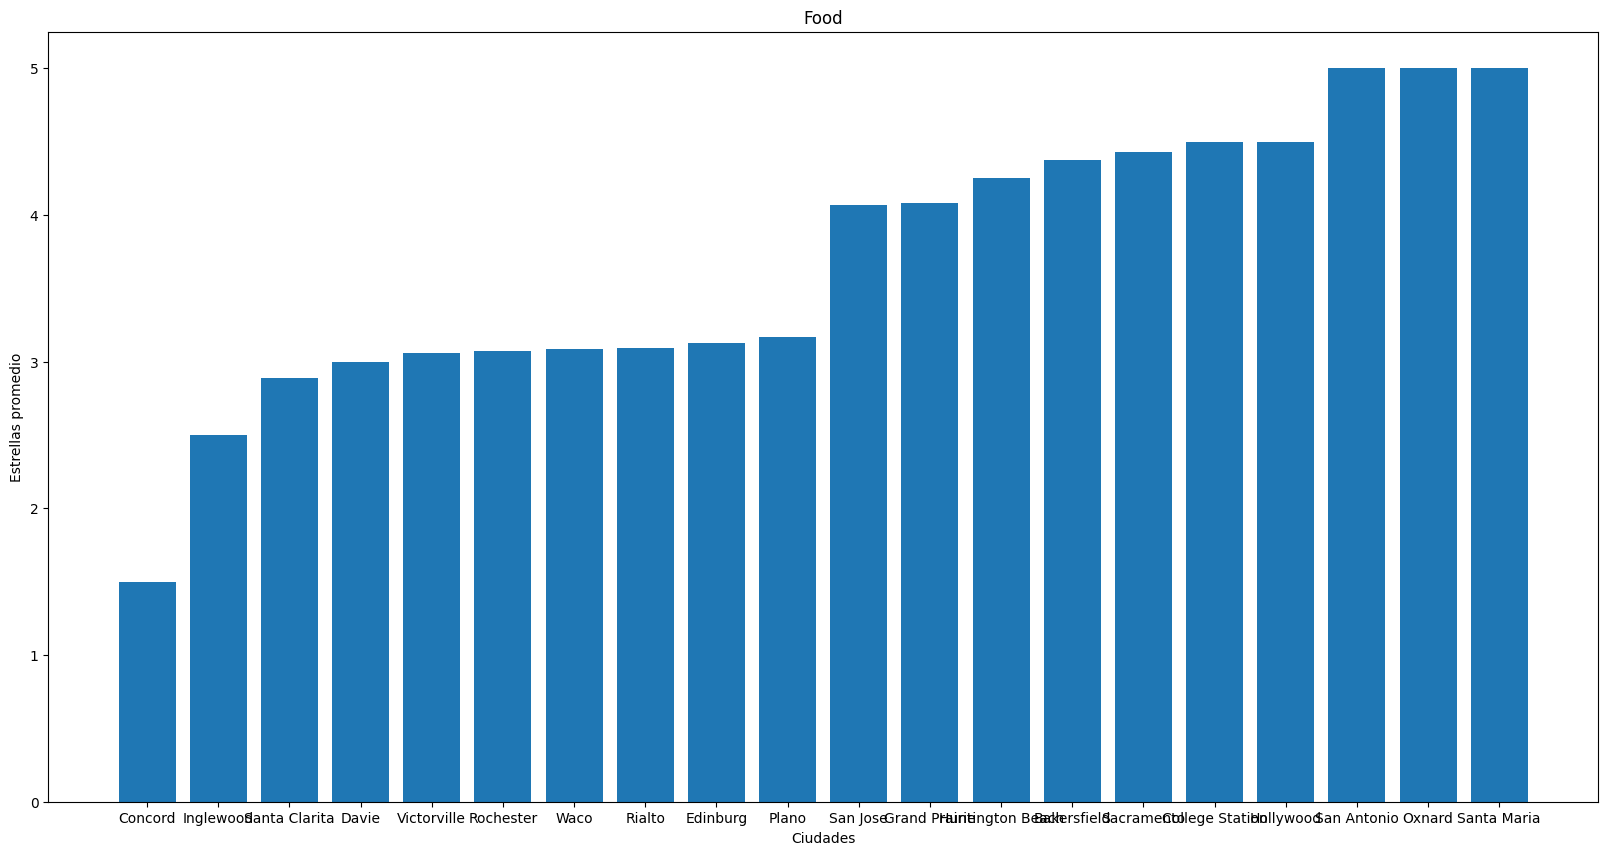

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
Ciudades=Ciudadestop+Ciudadestail
Estrellas=Estrellastop+Estrellastail
# Crear las barras
ax.bar(Ciudades, Estrellas)

# Etiquetas y título
ax.set_xlabel('Ciudades')
ax.set_ylabel('Estrellas promedio')
ax.set_title('Food')

ETL para alimentacion del modelo

In [51]:
catunique=df_ml.Descripcion.value_counts().head(200).index.tolist()

In [52]:
from fuzzywuzzy import fuzz,process
import functools

@functools.lru_cache(maxsize=None)  
def encontrar_mejor_coincidencia(ciudad):
    mejor_coincidencia = process.extractOne(ciudad, catunique)
    resultado = mejor_coincidencia[0] if mejor_coincidencia[1] >= calcular_umbral_similitud(len(ciudad)) else ciudad
    return resultado

def calcular_umbral_similitud(longitud_ciudad):
    umbral_base = 70
    umbral = umbral_base - (longitud_ciudad // 3)
    return max(umbral, umbral_base)

Con esta funcion se normalizan y reducen las categorias a unicamente 169 mismas que estan en las variables 'catunique'

In [53]:
df_ml['NDescripcion']=df_ml['Descripcion'].apply(encontrar_mejor_coincidencia)

C:\Users\EQUIPO\AppData\Local\Temp\ipykernel_13652\1189470951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['NDescripcion']=df_ml['Descripcion'].apply(encontrar_mejor_coincidencia)


Se filtran el dataframe para que unicamente los negocios dentro de estas categorias se mantengan ,
esto con el fin de solo utilizar categorias en las cuales haya una cantidad de negocios relevante

In [54]:
df_ml=df_ml[df_ml['NDescripcion'].isin(df_ml['NDescripcion'].value_counts().head(169).index.to_list())]

Base de datos preeliminar para alimentacion del modelo.


Como podemos observar en esta data hay negocios repetidos esto se debe a que las filas estan separadas por categoria, y varios negocios estan en varias categorias a la vez

In [56]:
df_ml

,name,id_business,stars,review_count,city,state,IdCategoria,Descripcion,NDescripcion
5,Hibachi Grill & Supreme Buffet,53235,2.0,19,Waco,Texas,15,Restaurants,Restaurants
6,Hibachi Grill & Supreme Buffet,53235,2.0,19,Waco,Texas,27,Japanese,Japanese
7,Hibachi Grill & Supreme Buffet,53235,2.0,19,Waco,Texas,31,Bars,Bars
8,Hibachi Grill & Supreme Buffet,53235,2.0,19,Waco,Texas,33,Nightlife,Nightlife
9,Hibachi Grill & Supreme Buffet,53235,2.0,19,Waco,Texas,141,Chinese,Chinese
...,...,...,...,...,...,...,...,...,...
264499,McDonald's,165136,1.5,53,St. Petersburg,Florida,29,Coffee & Tea,Coffee & Tea
264500,McDonald's,165136,1.5,53,St. Petersburg,Florida,54,Burgers,Burgers
264510,Wendy's,38585,1.5,36,College Station,Texas,6,Restaurants,Restaurants
264511,Wendy's,38585,1.5,36,College Station,Texas,12,Fast Food,Fast Food


In [57]:
df_ml[['city','state','NDescripcion']].to_csv('ciudades_categorias.csv',index=False)

In [58]:
df_ml.reset_index(inplace=True)

In [59]:
dfm=df_ml[['stars','city','state','NDescripcion']]

Comienza la transformacion de los datos para el entrenamiento del modelo

In [61]:

scaler = MinMaxScaler()

Se seleccionan las filas con las variables independtiendes en variable 'x'

In [62]:
x=dfm[['city','NDescripcion']]

Con la funcion .get_dummies se transforman en columnas todas las variables y se les asigna un 1 si hay presnecia o 0 si hay ausencia

In [63]:
df_dummies=pd.get_dummies(x,prefix='', prefix_sep='')

Le agregamos una columna con los id de sus respectivos negocios para poder agruparlos posteriormente.

In [64]:
df_dummies['id_business']=df_ml['id_business']

In [65]:
df_dummies

,Albany,Allen,Allentown,Antioch,Arlington,Austin,Bakersfield,Beaumont,Berkeley,Brownsville,...,Venues & Event Spaces,Veterinarians,Vietnamese,Waxing,Wine & Spirits,Wine Bars,Wineries,Women's Clothing,Yoga,id_business
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53235
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53235
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53235
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53235
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,165136
123136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,165136
123137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38585
123138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38585


Guardamos en la variable business una tabla donde se encuentran las relaciones entre el id de los negocios y sus respectivos calificaciones en estrellas por negocio

In [66]:
business=business[['id_business','stars',]]

Agrupamos por id la base de datos transformada por unificar por negocio.

In [67]:
df_dummies=df_dummies.groupby('id_business').sum()

In [68]:
df_dummies

,Albany,Allen,Allentown,Antioch,Arlington,Austin,Bakersfield,Beaumont,Berkeley,Brownsville,...,Vegetarian,Venues & Event Spaces,Veterinarians,Vietnamese,Waxing,Wine & Spirits,Wine Bars,Wineries,Women's Clothing,Yoga
id_business,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
166660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
df_dummies.reset_index(inplace=True)

Con el siguiente codigo se remplazan los valores mayores a 1 con 1 ya que al agrupar se sumaron dichos valores.

In [70]:
for i in df_dummies:
    if i=='id_business':
        continue
    for index,e in enumerate(df_dummies[i]):
        if e>1:
            df_dummies.at[index, i] = 1

Guardamos en la variable idcode los id que estan dentro de la base de datos transformada para posteriormente relacionarlos con un merge.

In [71]:
idcode=df_dummies[['id_business']]

In [72]:
idcode=idcode.merge(business,on='id_business',how='left')

Ya tenemos la variable dependiente correspondiente a los negocios en la data transformada

In [73]:
y=idcode['stars'].values

Reescalamos los datos

In [74]:
y_=scaler.fit_transform(y.reshape(-1, 1))

In [75]:
df_dummies['stars']=pd.DataFrame(y_)

Y eliminamos el ID

In [76]:
df_dummies.drop('id_business',axis=1,inplace=True)

Se tiene la matriz para alimentar el modelo ya reescalado con numeros entre 0 y 1

In [77]:
df_dummies

,Albany,Allen,Allentown,Antioch,Arlington,Austin,Bakersfield,Beaumont,Berkeley,Brownsville,...,Venues & Event Spaces,Veterinarians,Vietnamese,Waxing,Wine & Spirits,Wine Bars,Wineries,Women's Clothing,Yoga,stars
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.750
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.750
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.875
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.750
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500
28648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.875
28649,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.875
28650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.875


Se separan las variables de pendientes 'y' de las independientes 'X'

In [78]:
X = df_dummies.drop('stars', axis=1)
y = df_dummies['stars']

Se separa la data en entrenamiento y tests con una proporcion de 70 entrenamiento y 30 a testeo

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Random Forest

Eleccion de parametros y entrenamiento

In [80]:
model_forest=RandomForestRegressor(n_estimators=305,max_depth=60,min_samples_split=20,max_features=37)

In [81]:
model_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, max_features=37, min_samples_split=20,
                      n_estimators=305)

Pruebas

In [82]:
y_pred = model_forest.predict(X_test)

In [83]:
model_forest.score(X_test, y_test)

0.32120826161024363

In [84]:
#305,60,20,37
r2=r2_score(y_test, y_pred)
print('Coeficiente de determinacion es de:',r2)

Coeficiente de determinacion es de: 0.32120826161024363


In [85]:
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)

Error cuadrático medio: 0.031683092783167756


In [86]:
pruebaforest=y_test.reset_index()
pruebaforest['star_pred']=y_pred
pruebaforest

,index,stars,star_pred
0,17885,0.875,0.768859
1,10186,0.875,0.873999
2,17757,0.750,0.725432
3,15936,0.500,0.593466
4,12340,0.625,0.713381
...,...,...,...
8591,20218,0.750,0.695682
8592,1348,0.750,0.643233
8593,3264,0.750,0.816509
8594,26711,0.375,0.441606


Creacion del modelo

In [ ]:
from joblib import dump
dump(model_forest, 'modelo_RF3.joblib')

['modelo_RF3.joblib']

Desarrollo de la funcion de consulta del modelo

In [87]:
index_model=X.sample(1)
for i in index_model:
    index_model[i]=0

In [88]:
for i in index_model:
    if index_model[i].values==1:
        print(i)

In [89]:
index_model.to_csv('index_model3.csv',index=False)
index_model=pd.read_csv('index_model3.csv')

In [90]:
def prediccion(categoria, ciudad, categoria1=None, categoria2=None):
    index_model = pd.read_csv('index_model3.csv')
    
    if ciudad in index_model.columns.tolist(): 
        if categoria in index_model.columns.tolist():
            for i in index_model:
                if i == categoria:
                    index_model[i] = 1
                    
            for i in index_model:
                if i == ciudad:
                    index_model[i] = 1
                    
            if categoria1 is not None:
                if categoria1 in index_model.columns.tolist():
                    index_model[categoria1] = 1
                else:
                    return f'Esa categoría "{categoria1}" no existe'
                    
            if categoria2 is not None:
                if categoria2 in index_model.columns.tolist():
                    index_model[categoria2] = 1
                else:
                    return f'Esa categoría "{categoria2}" no existe'
                    
            e = model_forest.predict(index_model)
            return round(((e[0] - 0) * (5 - 1) / (1 - 0) + 1), 1)
        else:
            return 'Esa categoría no existe'
    else:
        return 'Esa ciudad no existe'

In [91]:
prediccion('Restaurants','Allen','Pizza','Bars')

3.5